# Pokemon GAN Training Notebook

## **Import libraries**

In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import PokemonGensDataset
from ACGAN import AuxGAN
from utils import show_tensor_images, flatten_dict, return_tensor_images, inverse_normalize
import variable as var
import os
import cuda_monitoring as cuda_mon
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
import torchvision.utils as vutils

In [4]:
#cuda_mon.get_tensor_info()
#cuda_mon.get_gpu_memory_info()

## **Load labels**

In [5]:
resume_training = True
train_number = 14
gan_id = f"acgan_pokemon_train_{train_number}"

greyscale = False
resize_image_dim = 64
n_conv_block = 3
batch_size = 128
label_name = 'Body_Style'

print(f"Greyscale: {greyscale}")
print(f"Real: {resize_image_dim}x{resize_image_dim} images")
print(f"Fake: {2**(3 + n_conv_block)}x{2**(3 + n_conv_block)} images")

Greyscale: False
Real: 64x64 images
Fake: 64x64 images


In [6]:
dset = PokemonGensDataset(label_name=label_name, greyscale=greyscale,
                          resize=[resize_image_dim, resize_image_dim], gens_to_remove=("gen8", ))
dloader = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=0)

In [7]:
len(dset)

6450

dloader = DataLoader(
    MNIST(os.environ['DATASETS'], 
          download=False, 
          transform=transforms.Compose([transforms.ToTensor(), 
                                        transforms.Resize([resize_image_dim, resize_image_dim])
                                       ])
         ), 
    batch_size=batch_size,
    shuffle=True)

In [8]:
len(dloader)*batch_size

6528

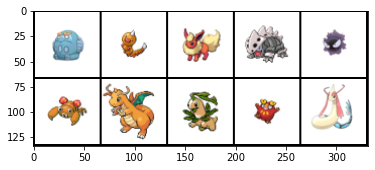

In [9]:
images, labels = next(iter(dloader))
show_tensor_images(images)

In [10]:
images.max()

tensor(1.5113)

## **GAN Component**

In [11]:
betas = {'1': .5, '2': .999}
n_channel = 1 if greyscale else 3
n_feature = 32
z_dim = 100
n_classes = len(dset.label_id_to_label_name)
load_inception = False
    
params = {'gen': {'n_feature': int(n_feature),
                  'n_channel': int(n_channel),
                  'lr': 1e-4,
                  'betas': betas},
          'disc': {'n_channel': int(n_channel),
                   'n_feature': int(n_feature),
                   'lr': 1e-4,
                   'betas': betas},
          'z_dim': int(z_dim),
          'n_conv_block': int(n_conv_block),
          'n_classes': int(n_classes),
          'dataset': dset.describe(),
          'batch_size': int(batch_size)
         }

## **GAN INIT AND TRAINING**

In [12]:
gan = AuxGAN(params)
if os.path.exists(f'data/models/{gan_id}.pth'):
    print('RESUMING TRAINING...')
    gan.load_model(f'data/models/{gan_id}.pth')
else:
    print('NEW TRAINING...')
print(f'id: {gan_id}')

RESUMING TRAINING...
id: acgan_pokemon_train_14


In [11]:
gan.init_tensorboard(main_dir='runs', subdir=gan_id, port=8008)

In [13]:
gan.train(n_epoch=100, dataloader=dloader, gan_id=gan_id)

 23%|██▎       | 23/100 [02:31<08:26,  6.58s/it]


KeyboardInterrupt: 

## **RESULT VIZUALIZATION**

class: quadruped


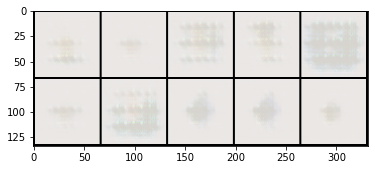

fake/real precision: 1.0
auxiliary precision: 0.3
--------------------------------------------------------------------------
class: bipedal_tailed


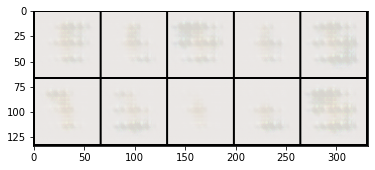

fake/real precision: 0.7
auxiliary precision: 0.9
--------------------------------------------------------------------------
class: insectoid


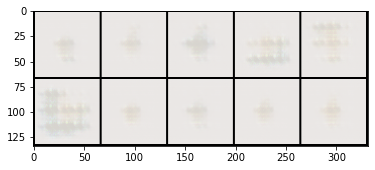

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: serpentine_body


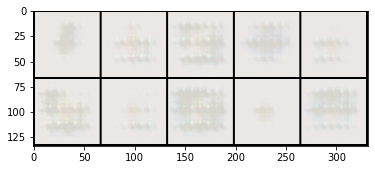

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: four_wings


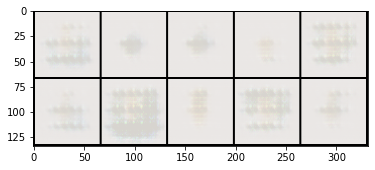

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: two_wings


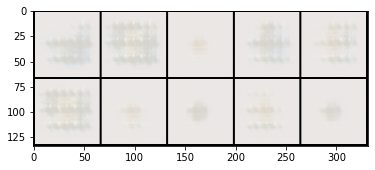

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: bipedal_tailless


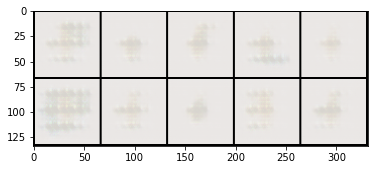

fake/real precision: 1.0
auxiliary precision: 0.9
--------------------------------------------------------------------------
class: head_legs


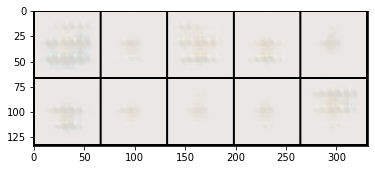

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: head_base


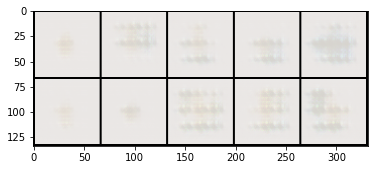

fake/real precision: 0.9
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: multiple_bodies


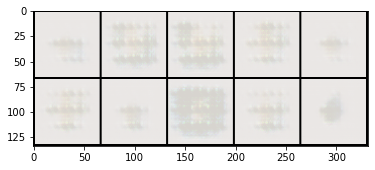

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: several_limbs


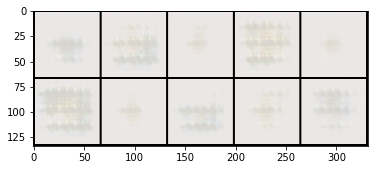

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: head_arms


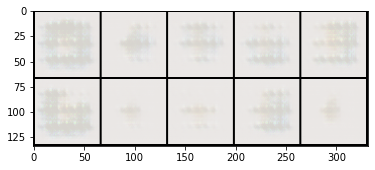

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: with_fins


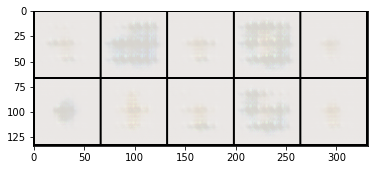

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: head_only


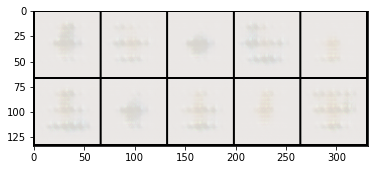

fake/real precision: 0.9
auxiliary precision: 0.0
--------------------------------------------------------------------------


In [21]:
for label_id, label_name in dset.label_id_to_label_name.items():
    print(f"class: {dset.label_id_to_label_name[label_id]}")
    with torch.no_grad():
        fakes, classes = gan.generate_fake(10, train=False, being_class=label_id)
        adv, aux = gan.discriminator(fakes)
        adv_label = adv < .5
        aux_label = torch.argmax(aux, dim=1) == classes.cuda()

    show_tensor_images(fakes)
    print(f"fake/real precision: {round((adv_label.sum()/ len(adv_label)).item(), 2)}")
    print(f"auxiliary precision: {round((aux_label.sum()/ len(aux_label)).item(), 2)}")
    print("--------------------------------------------------------------------------")

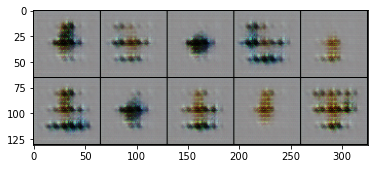

In [22]:
plt.imshow(np.transpose(vutils.make_grid(
    fakes.to(var.device), 
    nrow=5,
    padding=1,
    value_range=(-1, 1),
    scale_each=True,
    normalize=True).cpu(),(1,2,0)))

In [13]:
import torchvision
torchvision.__version__

'0.9.0'

In [32]:
fakes.max()

tensor(0.7169, device='cuda:0')

In [33]:
images.max()

tensor(1.5113)

In [24]:
len(dset.label_map)

18

tensor(0.9117) tensor(0.8902)
tensor(0.9117) tensor(0.8902)
tensor(0.9117) tensor(0.8901)
tensor(0.9117) tensor(0.8902)
tensor(0.9117) tensor(0.8902)
tensor(0.9117) tensor(0.8902)
tensor(0.9117) tensor(0.8901)
tensor(0.9117) tensor(0.8901)
tensor(0.9117) tensor(0.8902)
tensor(0.9117) tensor(0.8901)
tensor(0.9117) tensor(0.8901)
tensor(0.9117) tensor(0.8902)
tensor(0.9117) tensor(0.8902)
tensor(0.9117) tensor(0.8901)


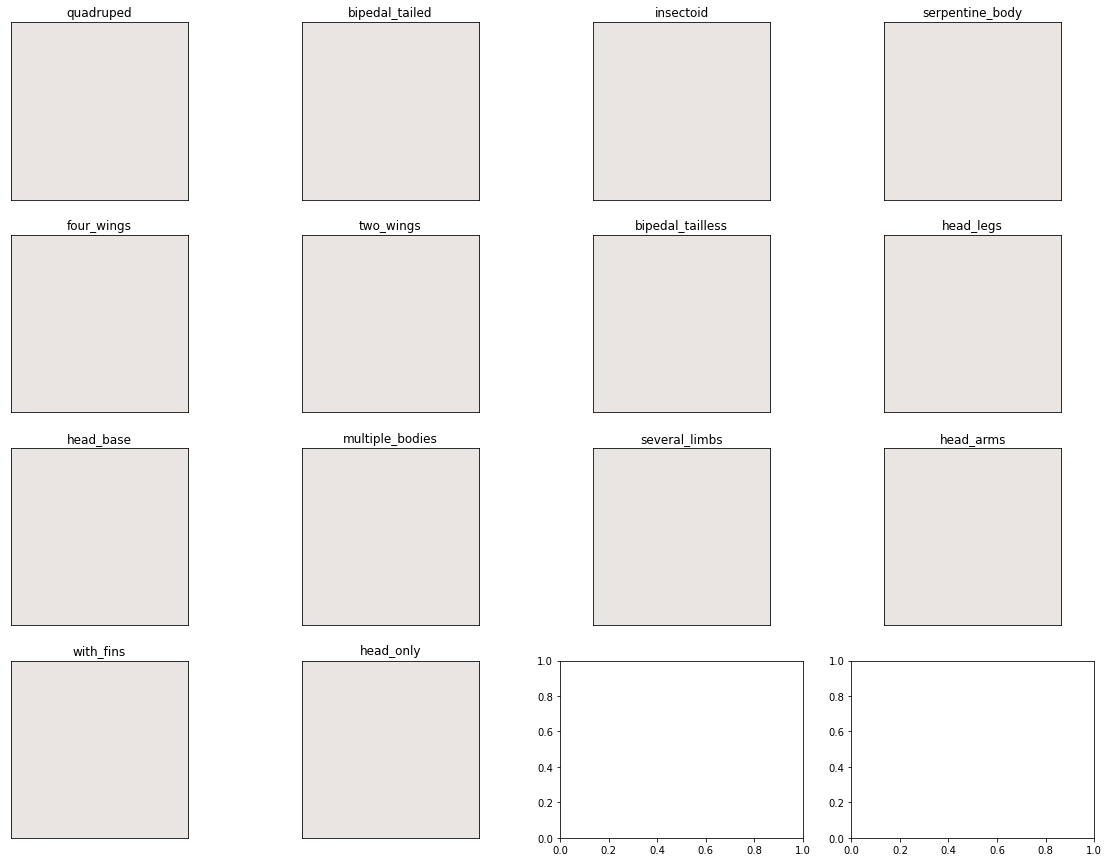

In [34]:
being_class = 9
n = 1
noise = torch.ones(n, z_dim, 1, 1, device=var.device) + 10
noise = gan.get_random_noise(n)
n_label = len(dset.label_id_to_label_name)
n_label_per_row = 4
n_label_per_col = (n_label // n_label_per_row) + 1
fig, axes = plt.subplots(figsize=(20, 3 * 5) , nrows=n_label_per_row, 
                                 ncols=n_label_per_col)
for idx, (label_id, label_name) in enumerate(dset.label_id_to_label_name.items()):
    with torch.no_grad():
        classes = torch.ones((n, ), device=var.device).long() * label_id
        gan.generator.eval()
        fakes = gan.generator.forward(noise, classes)
        
    i = idx // n_label_per_col
    j = idx % n_label_per_col
    fakes = inverse_normalize(fakes)
    with warnings.catch_warnings():
        
        axes[i][j].imshow(fakes[0].cpu().permute(1, 2, 0))
    print(fakes[0].cpu().max(),fakes[0].cpu().min())
    axes[i][j].set_title(f"{dset.label_id_to_label_name[label_id]}")
    axes[i][j].xaxis.set_visible(False)
    axes[i][j].yaxis.set_visible(False)
    

In [89]:
from matplotlib.lines import Line2D

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=15) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

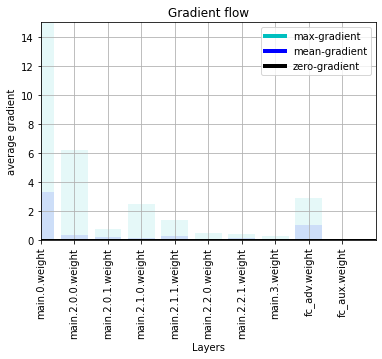

In [90]:
plot_grad_flow(gan.discriminator.named_parameters())